# Mock Challenge Level 2 --- `LGal` mocks

In [1]:
import os
import pickle
import numpy as np 
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#if 'NERSC_HOST' not in os.environ.keys():
#    mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
import gqp_mc.util as UT

In [3]:
from provabgs import infer as Infer
from provabgs import models as Models

# read mock spectra

In [4]:
theta_obs = pickle.load(open('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/l2.theta.p', 'rb'))
flux_obs = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/mocha_p2.flux.npy')
ivar_obs = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/mocha_p2.ivar.npy')

[Text(0, 0, 'g'),
 Text(0, 0, 'r'),
 Text(0, 0, 'z'),
 Text(0, 0, 'W1'),
 Text(0, 0, 'W2')]

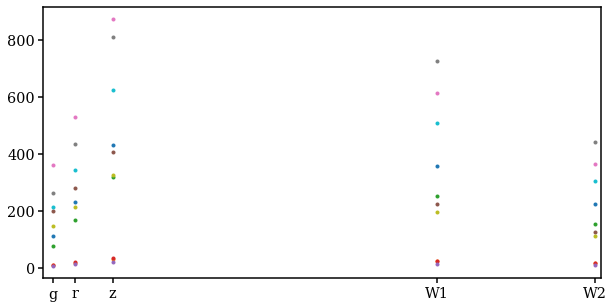

In [5]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for ii, f, i in zip(range(10), flux_obs, ivar_obs): 
    sub.errorbar([4720., 6415., 9260., 34000, 46000.], f[:5], yerr=i[:5]**-0.5, fmt='.C%i' % ii)
sub.set_xlim(4000, 46500)
sub.set_xticks([4720., 6415., 9260., 34000, 46000.])
sub.set_xticklabels(['g', 'r', 'z', 'W1', 'W2'])
#sub.set_ylim(0., 20)

# load in MCMC chains run on cori

In [6]:
prior = Infer.load_priors([
    Infer.UniformPrior(7.5, 12.5, label='sed'), 
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # burst fraction
    Infer.UniformPrior(1e-2, 13.27, label='sed'), # tburst
    Infer.LogUniformPrior(4.5e-5, 1.5e-2, label='sed'),# uniform priors on ZH coeffb
    Infer.LogUniformPrior(4.5e-5, 1.5e-2, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2, 1, label='sed')     # uniform priors on dust_index 
])

m_nmf = Models.NMF(burst=True, emulator=True)
desi_mcmc = Infer.desiMCMC(model=m_nmf, prior=prior)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [7]:
chain_dir = os.path.join(UT.dat_dir(), 'mini_mocha', 'L2')
f_chain = lambda i: os.path.join(chain_dir, 'P2.provabgs.%i.chain.p' % i)

In [8]:
igals, chains = [], []
for i in range(3000): 
    if os.path.isfile(f_chain(i)): 
        igals.append(i)
        chains.append(pickle.load(open(f_chain(i), 'rb')))

In [9]:
print(len(igals))

2089


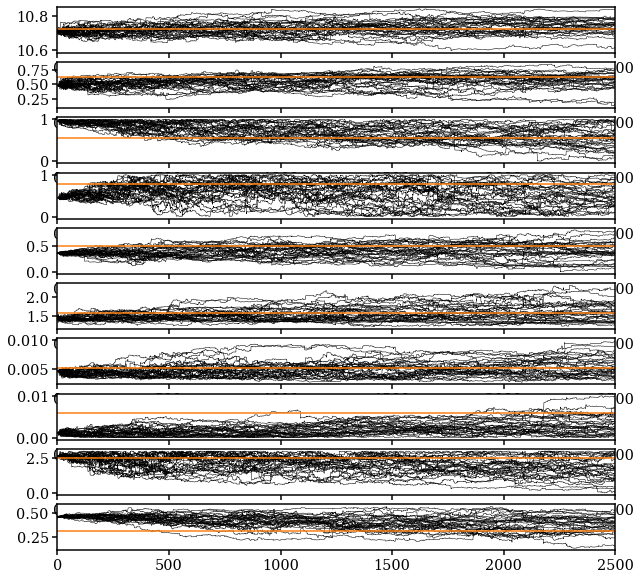

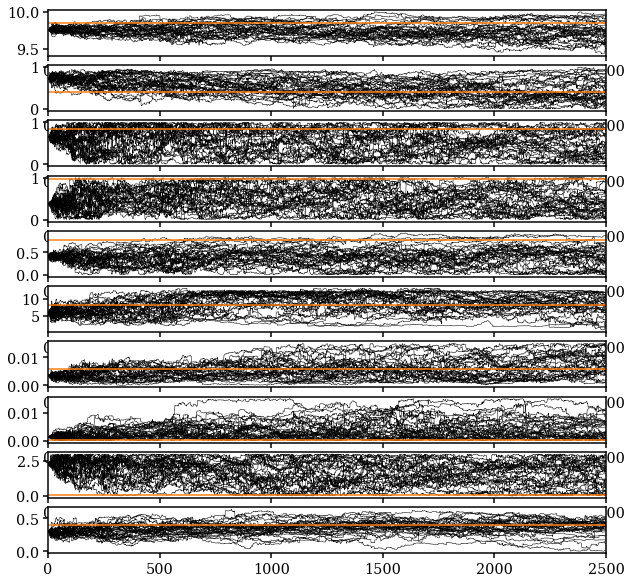

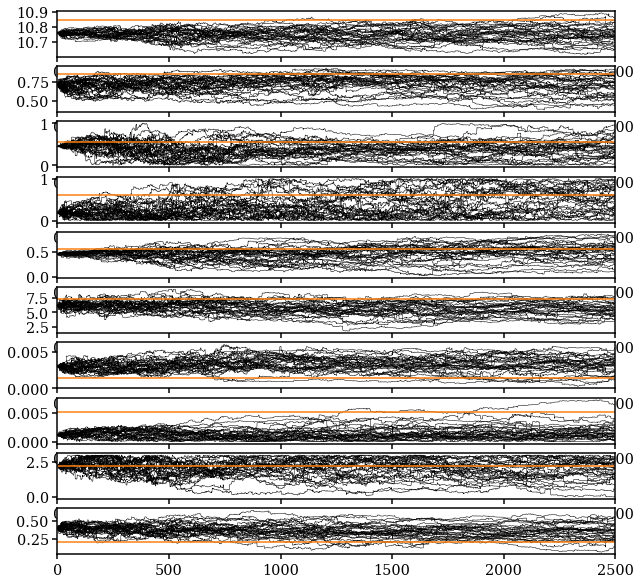

In [10]:
# examine the chains     
for i, chain in zip(igals[:3], chains): 
    unt_theta_bf = prior.untransform(chain['theta_bestfit'])
    fig = plt.figure(figsize=(10, 10))
    for ii in range(unt_theta_bf.shape[0]-1): 
        sub = fig.add_subplot(unt_theta_bf.shape[0]-1, 1, ii+1)
        for j in range(30): 
            unt_chain_i = desi_mcmc.prior.untransform(chain['mcmc_chain'][:,j,:])
            sub.plot(unt_chain_i[:,ii], c='k', lw=0.5)
        sub.axhline(unt_theta_bf[ii], color='C1')
        sub.set_xlim(0,2500)

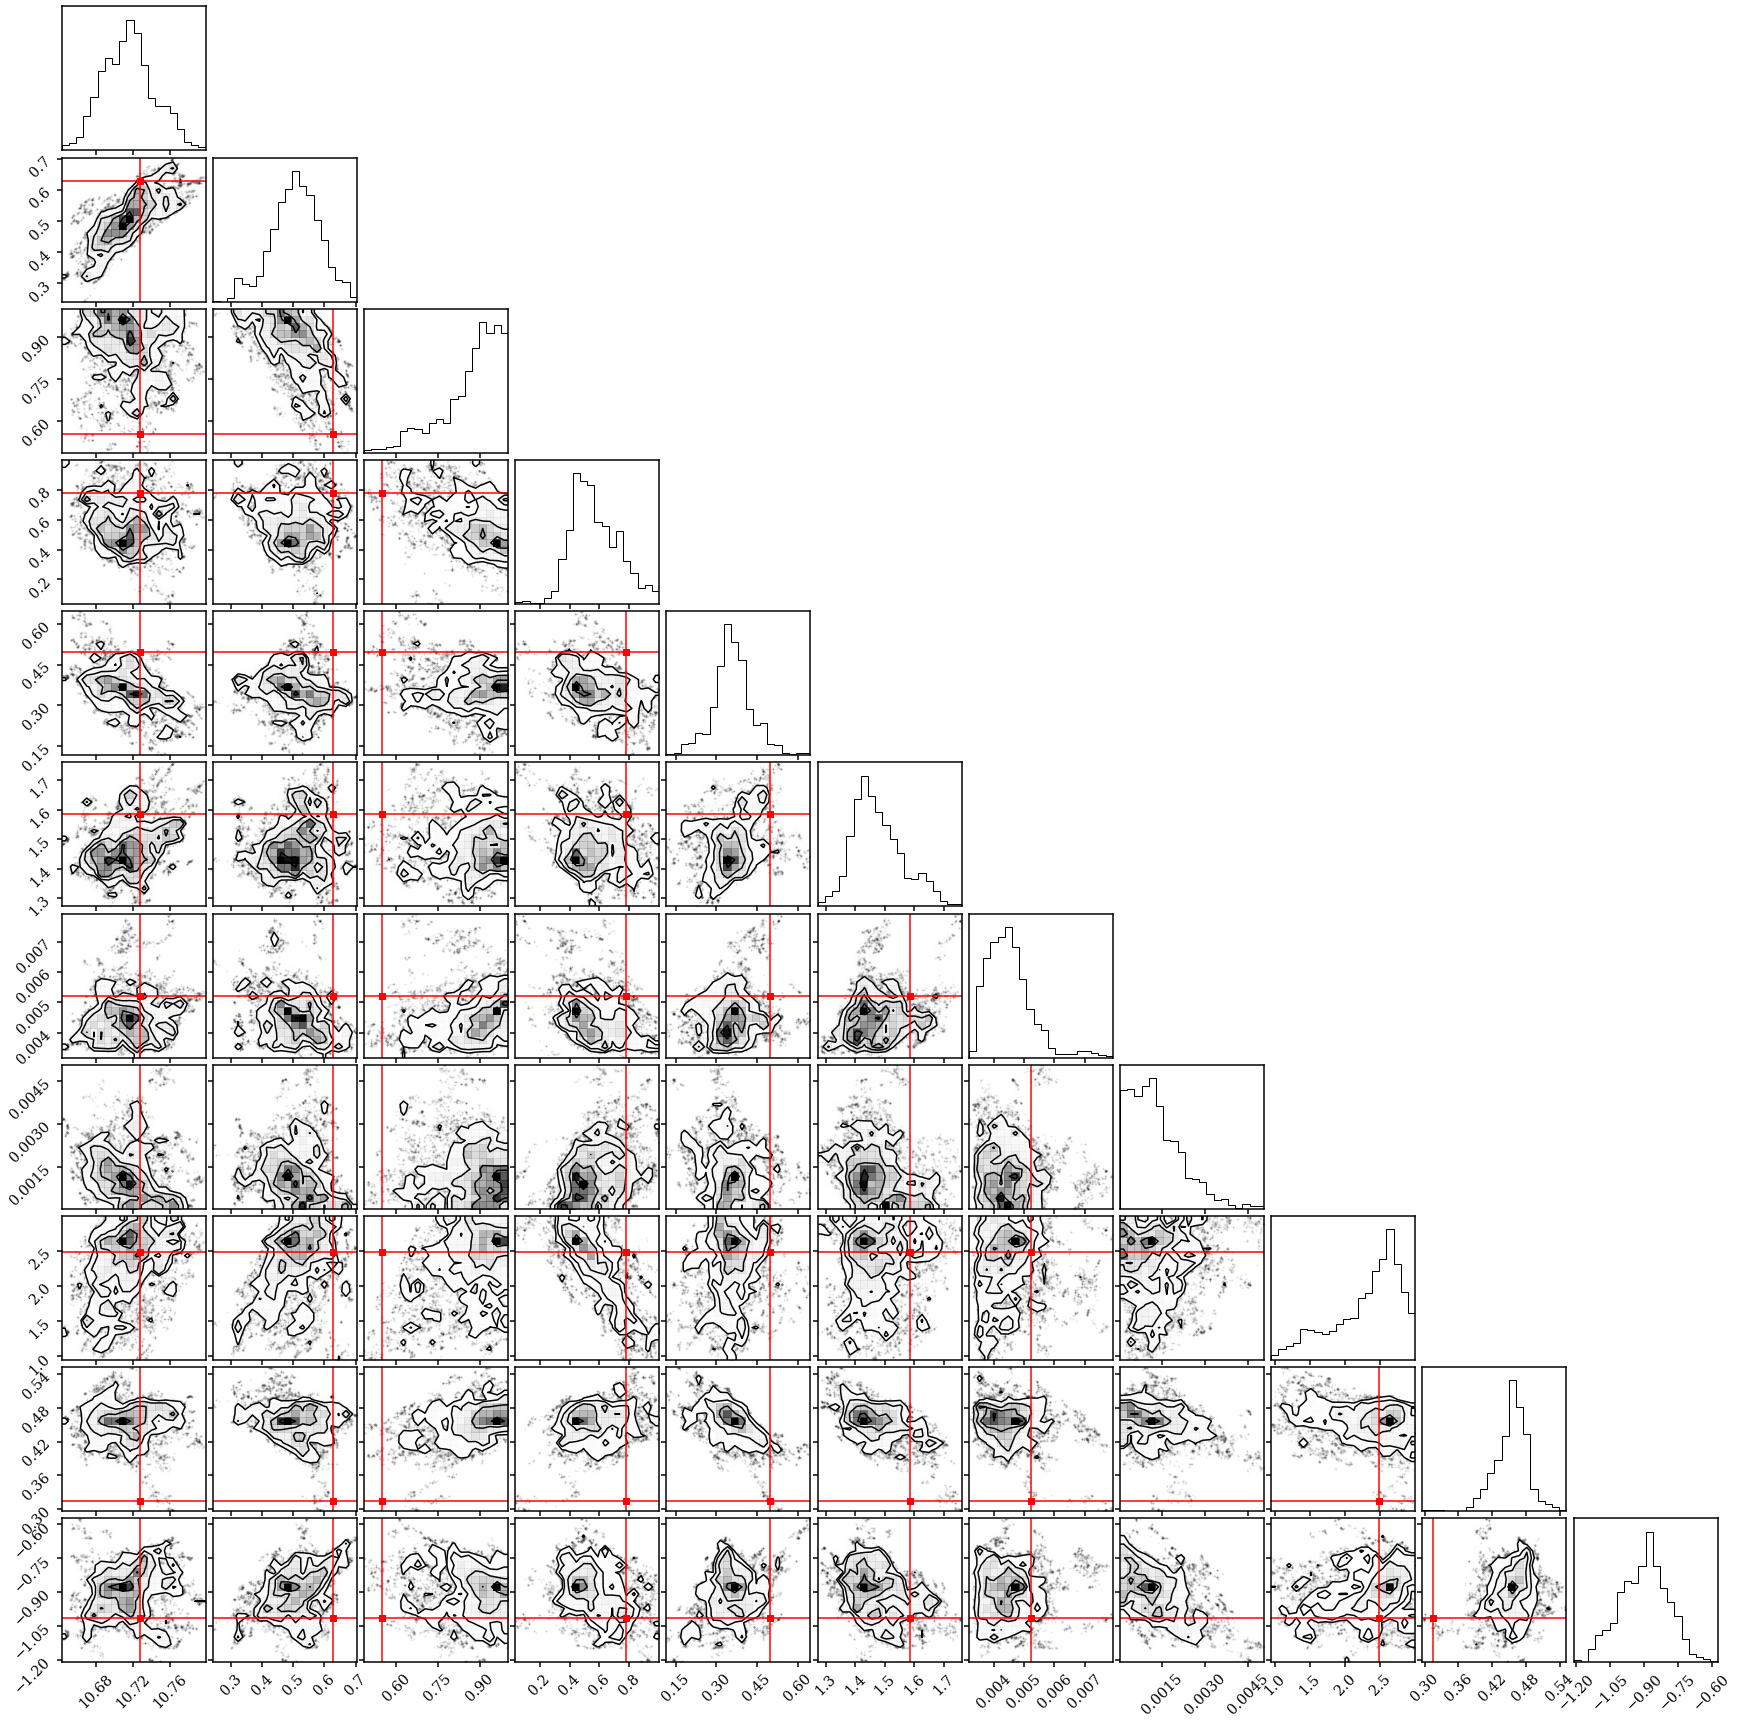

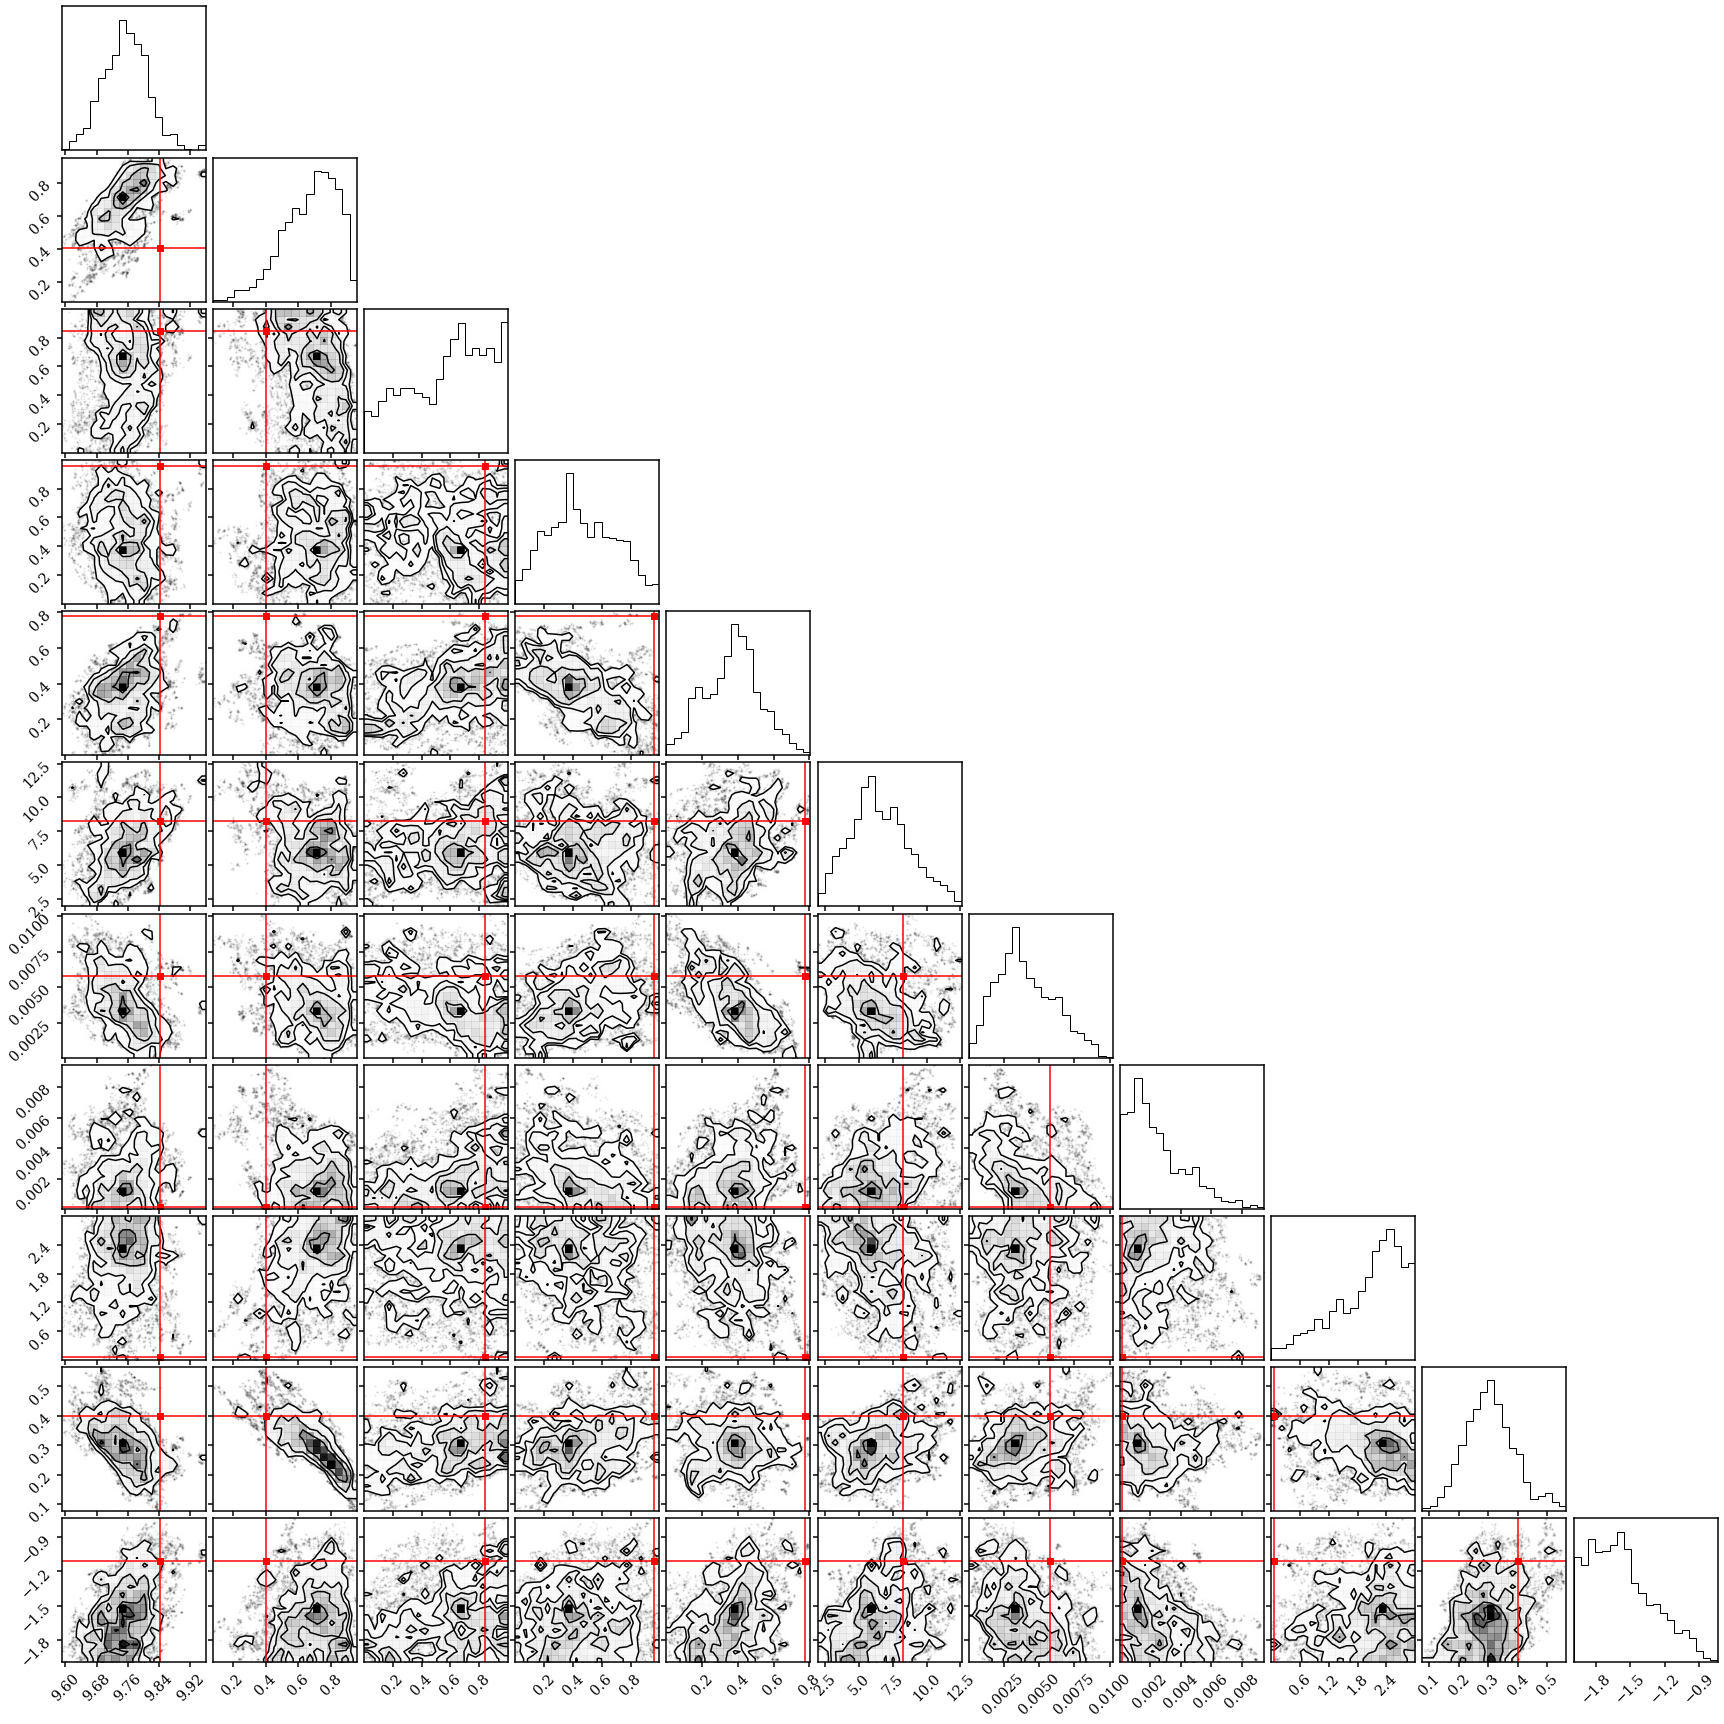

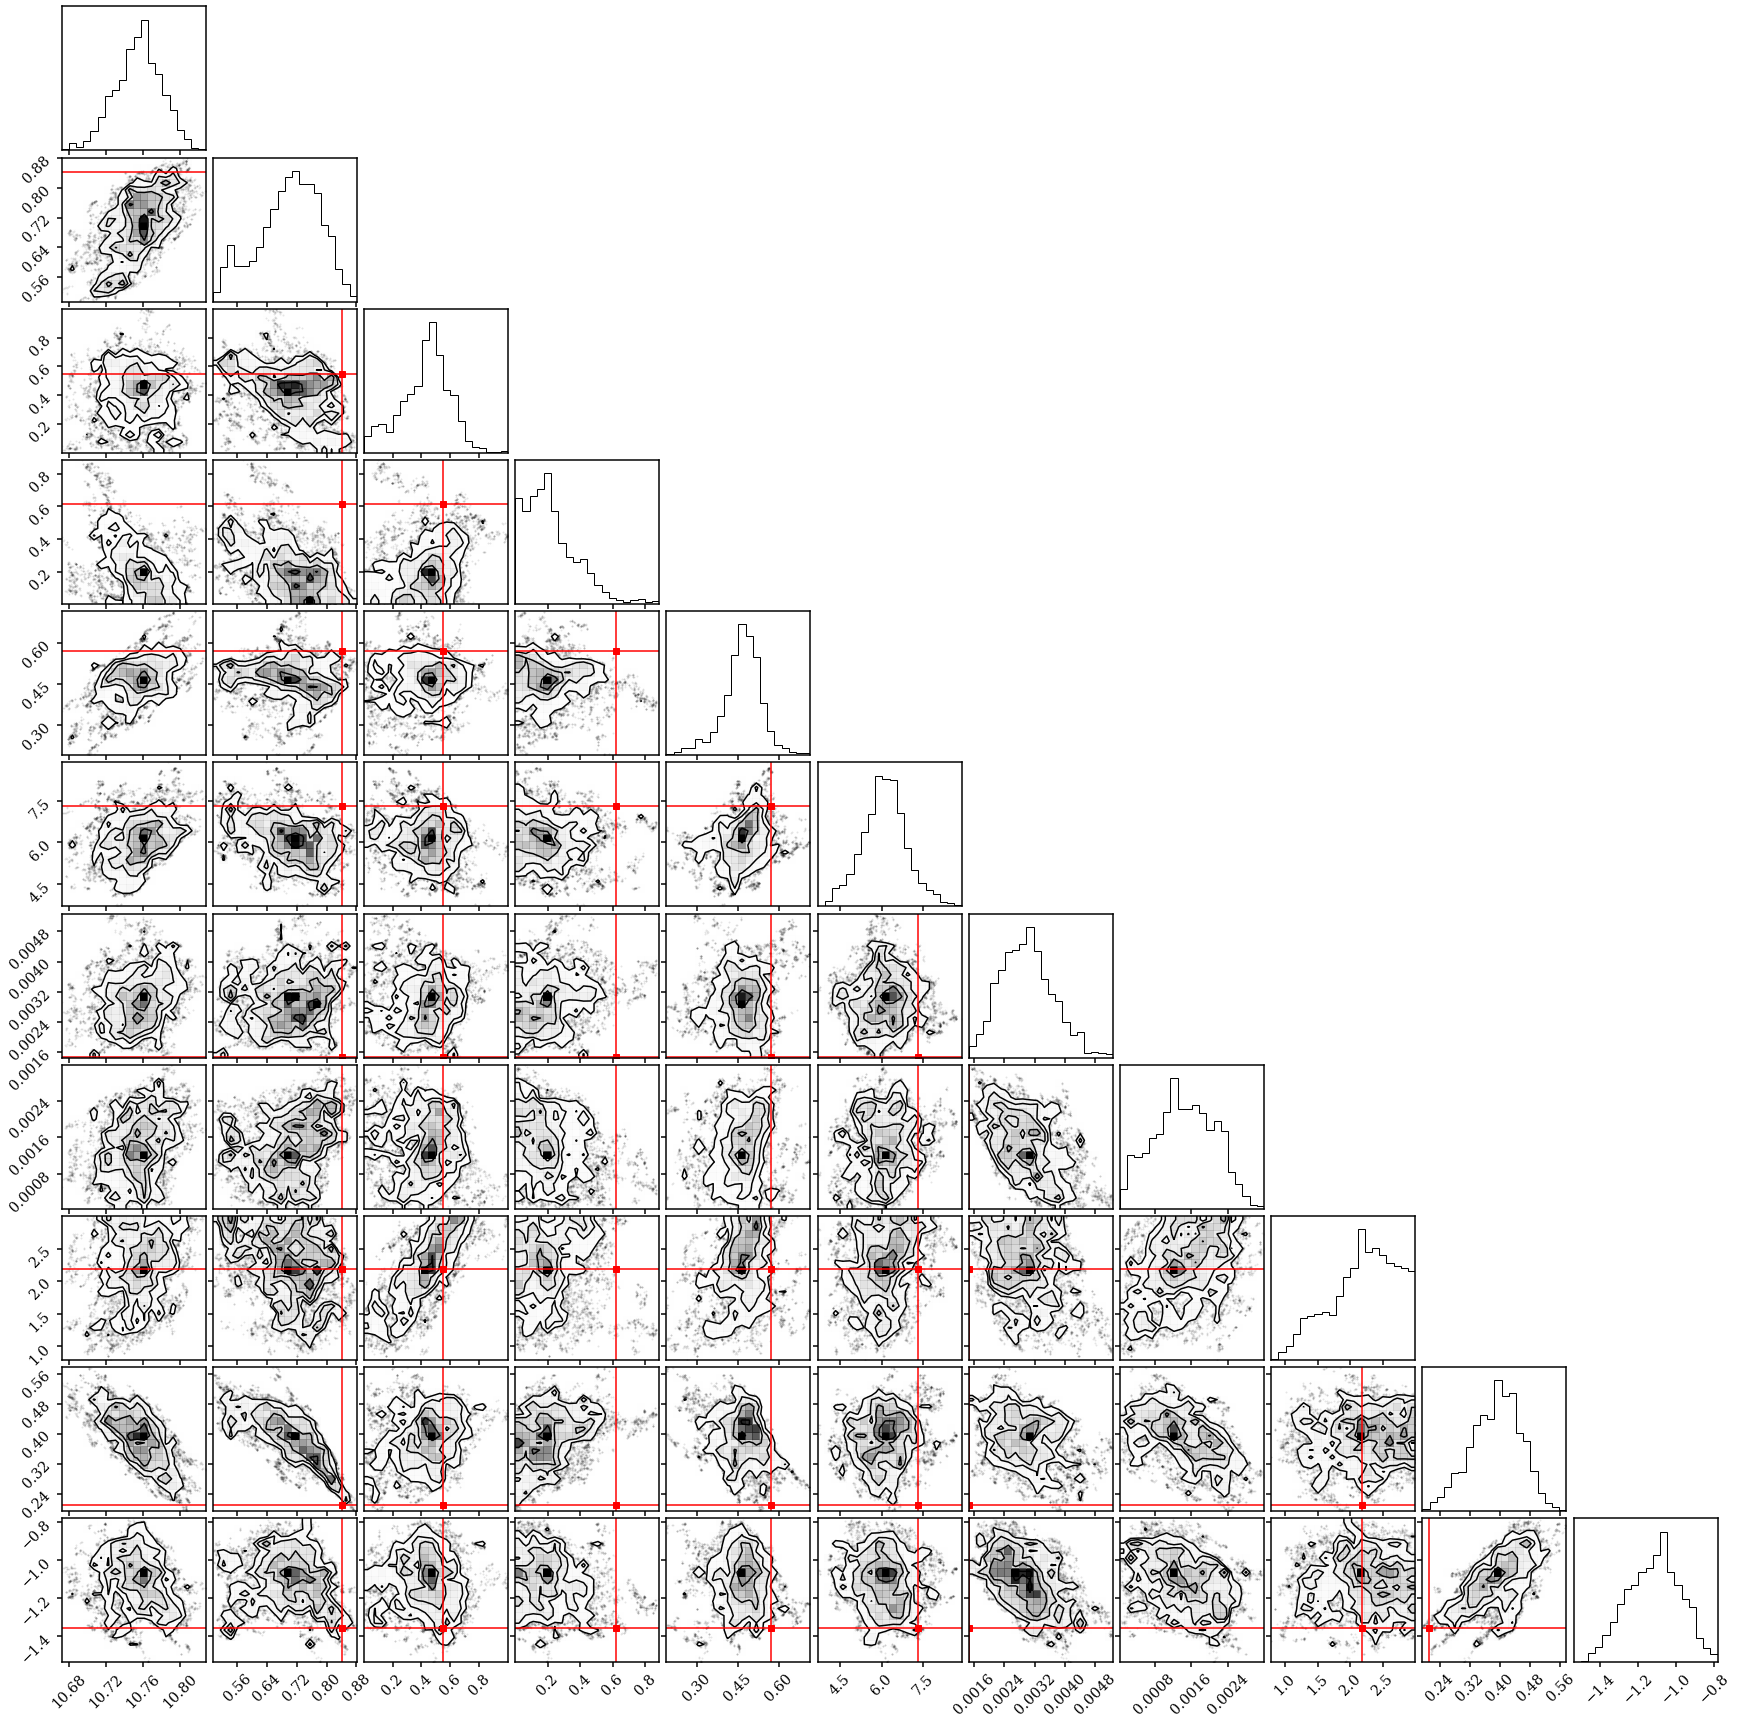

In [11]:
# examine the chains     
for i, chain in zip(igals[:3], chains): 
    unt_theta_bf = prior.untransform(chain['theta_bestfit'])
    unt_chain = prior.untransform(desi_mcmc._flatten_chain(chain['mcmc_chain'][:500,:,:]))
    
    fig = DFM.corner(unt_chain)
    
    axes = np.array(fig.axes).reshape((unt_theta_bf.shape[0], unt_theta_bf.shape[0]))

    # Loop over the histograms
    for yi in range(unt_theta_bf.shape[0]):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(unt_theta_bf[xi], color="r")
            ax.axhline(unt_theta_bf[yi], color="r")
            ax.plot(unt_theta_bf[xi], unt_theta_bf[yi], "sr")

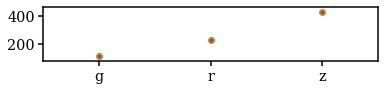

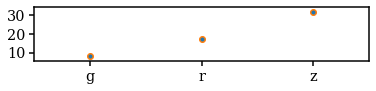

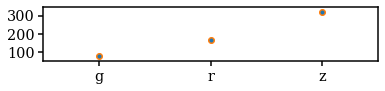

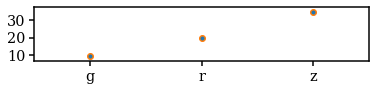

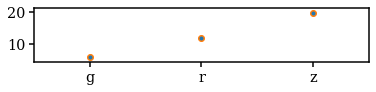

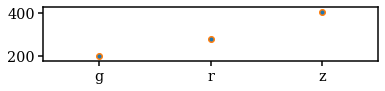

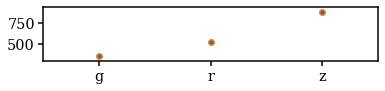

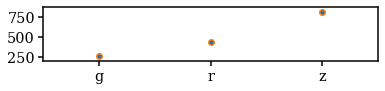

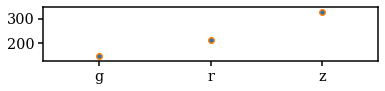

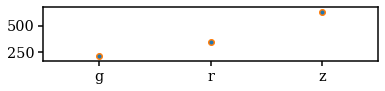

In [12]:
# examine the chains     
for i, chain in zip(igals[:10], chains): 
    fig = plt.figure(figsize=(6,1))
    sub = fig.add_subplot(111)
    sub.errorbar(range(3), flux_obs[i][:3], yerr=ivar_obs[i][:3]**-0.5, fmt='.C0')
    sub.scatter(range(3), chain['flux_photo_model'], c='C1')
    sub.set_xlim(-0.5, 2.5)
    sub.set_xticks(range(3))
    sub.set_xticklabels(['g', 'r', 'z'])

compile true and inferred thetas

In [10]:
flat_chains = []
logMstar_true, logMstar_inf = [], [] 
logSSFR_true, logSSFR_inf = [], [] 
logZ_MW_true, logZ_MW_inf = [], []
tage_MW_true, tage_MW_inf = [], [] 
tauism_true, tauism_inf = [], [] 

for i, chain in zip(igals, chains): 
    flat_chain = desi_mcmc._flatten_chain(chain['mcmc_chain'][1500:,:,:])       
    flat_chains.append(flat_chain)
    
    z_obs = theta_obs['redshift'][i]
    
    logMstar_true.append(theta_obs['logM_total'][i])
    logMstar_inf.append(flat_chain[:,0])
    
    logSSFR_true.append(np.log10(theta_obs['sfr_1gyr'][i]) - theta_obs['logM_total'][i])
    logSSFR_inf.append(np.log10(m_nmf.avgSFR(flat_chain, zred=z_obs, dt=1.0)) - flat_chain[:,0])
    
    logZ_MW_true.append(np.log10(theta_obs['Z_MW'])[i])
    logZ_MW_inf.append(np.log10(m_nmf.Z_MW(flat_chain, zred=z_obs)))
    
    tage_MW_true.append(theta_obs['t_age_MW'][i])
    tage_MW_inf.append(m_nmf.tage_MW(flat_chain, zred=z_obs))
    
    tauism_true.append(theta_obs['tau_ism'][i])
    tauism_inf.append(flat_chain[:,-2])
    
flat_chains = np.array(flat_chains)

logMstar_true = np.array(logMstar_true)
logMstar_inf = np.array(logMstar_inf)

logSSFR_true = np.array(logSSFR_true).flatten()
logSSFR_inf = np.array(logSSFR_inf)

logZ_MW_true = np.array(logZ_MW_true).flatten()
logZ_MW_inf = np.array(logZ_MW_inf)

tage_MW_true = np.array(tage_MW_true).flatten()
tage_MW_inf = np.array(tage_MW_inf)

tauism_true = np.array(tauism_true)
tauism_inf = np.array(tauism_inf)

In [11]:
props_chain = np.stack([logMstar_inf, logSSFR_inf, logZ_MW_inf, tage_MW_inf, tauism_inf], axis=2)
props_truth = np.stack([logMstar_true, logSSFR_true, logZ_MW_true, tage_MW_true, tauism_true], axis=1)

In [12]:
# save compiled chains and properties to file

# flat chains
np.save(os.path.join(chain_dir, 'P2.flat_chains.npy'), flat_chains) 
#  proerties
np.save(os.path.join(chain_dir, 'P2.prop_chains.npy'), props_chain) 

np.save(os.path.join(chain_dir, 'P2.prop_truths.npy'), props_truth)

In [13]:
# lets calculate the median, +/- sigma for each of the derived properties
logm_q = np.array([DFM.quantile(logMstar_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
logssfr_q = np.array([DFM.quantile(logSSFR_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
logzmw_q = np.array([DFM.quantile(logZ_MW_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
tagemw_q = np.array([DFM.quantile(tage_MW_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])
tauism_q = np.array([DFM.quantile(tauism_inf[i], [0.16, 0.5, 0.84]) for i in range(flat_chains.shape[0])])

(0.0, 3)

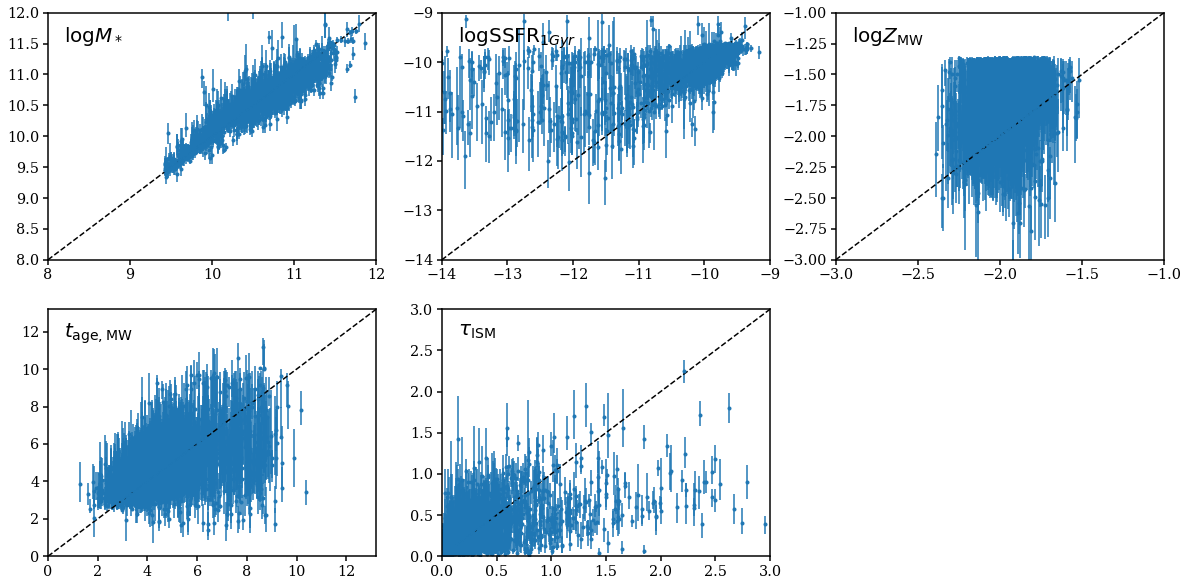

In [14]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(231)
sub.errorbar(logMstar_true, logm_q[:,1], 
             yerr=[logm_q[:,1]-logm_q[:,0], logm_q[:,2]-logm_q[:,1]],
             fmt='.C0')
sub.plot([8., 12.], [8., 12], c='k', ls='--')
sub.text(0.05, 0.95, r'$\log M_*$', transform=sub.transAxes, ha='left', va='top', fontsize=20)
sub.set_xlim(8., 12.)
sub.set_ylim(8., 12.)

sub = fig.add_subplot(232)
sub.errorbar(logSSFR_true, logssfr_q[:,1], 
             yerr=[logssfr_q[:,1]-logssfr_q[:,0], logssfr_q[:,2]-logssfr_q[:,1]], 
             fmt='.C0')
sub.plot([-9., -15.], [-9., -15], c='k', ls='--')
sub.text(0.05, 0.95, r'$\log {\rm SSFR}_{1Gyr}$', transform=sub.transAxes, ha='left', va='top', fontsize=20)
sub.set_xlim(-14, -9.)
sub.set_ylim(-14, -9.)

sub = fig.add_subplot(233)
sub.errorbar(logZ_MW_true, logzmw_q[:,1], 
             yerr=[logzmw_q[:,1] - logzmw_q[:,0], logzmw_q[:,2] - logzmw_q[:,1]], 
             fmt='.C0')
sub.text(0.05, 0.95, r'$\log Z_{\rm MW}$', transform=sub.transAxes, ha='left', va='top', fontsize=20)
sub.plot([-3., -1], [-3, -1], c='k', ls='--')
sub.set_xlim(-3., -1)
sub.set_ylim(-3., -1)

sub = fig.add_subplot(234)
sub.errorbar(tage_MW_true, tagemw_q[:,1], 
             yerr=[tagemw_q[:,1] - tagemw_q[:,0], tagemw_q[:,2] - tagemw_q[:,1]], 
             fmt='.C0')
sub.text(0.05, 0.95, r'$t_{\rm age, MW}$', transform=sub.transAxes, ha='left', va='top', fontsize=20)
sub.plot([0., 13.2], [0., 13.2], c='k', ls='--')
sub.set_xlim(0., 13.2)
sub.set_ylim(0., 13.2)

sub = fig.add_subplot(235)
sub.errorbar(tauism_true, tauism_q[:,1], 
             yerr=[tauism_q[:,1] - tauism_q[:,0], tauism_q[:,2] - tauism_q[:,1]], 
             fmt='.C0')
sub.text(0.05, 0.95, r'$\tau_{\rm ISM}$', transform=sub.transAxes, ha='left', va='top', fontsize=20)
sub.plot([0., 3.], [0., 3.], c='k', ls='--')
sub.set_xlim(0., 3)
sub.set_ylim(0., 3)

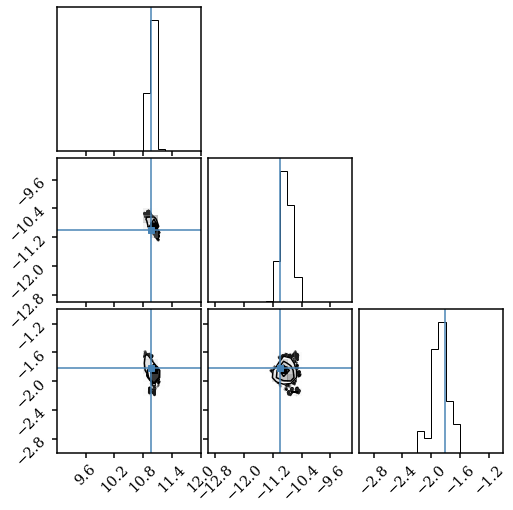

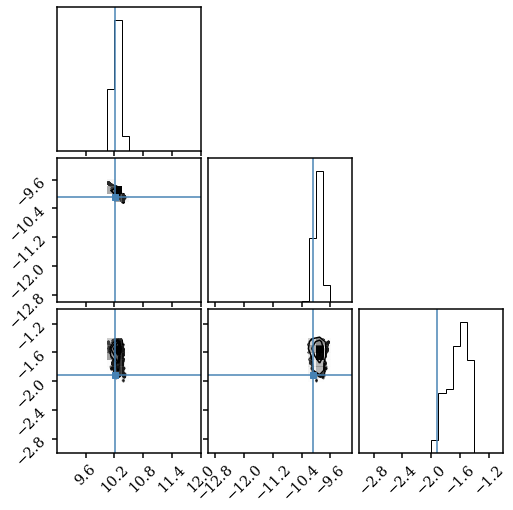

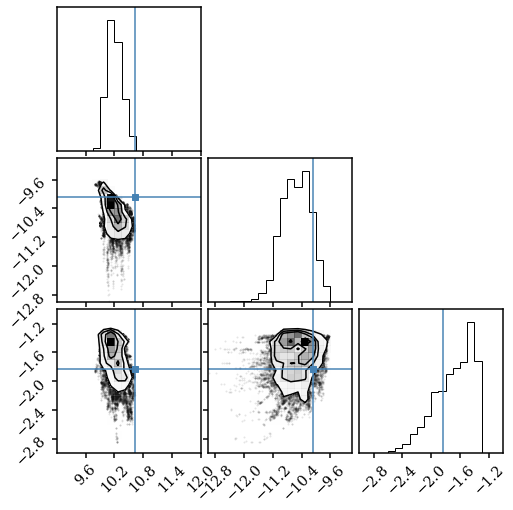

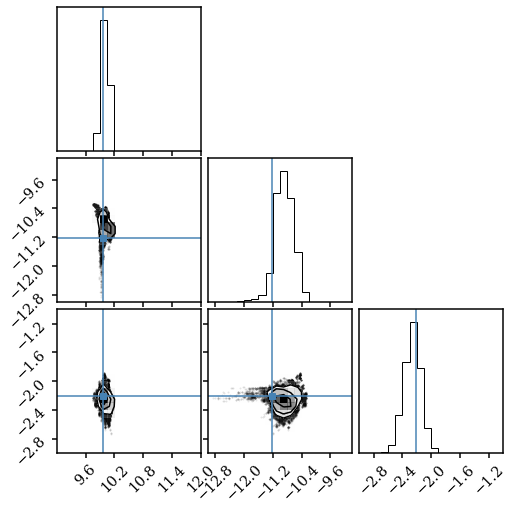

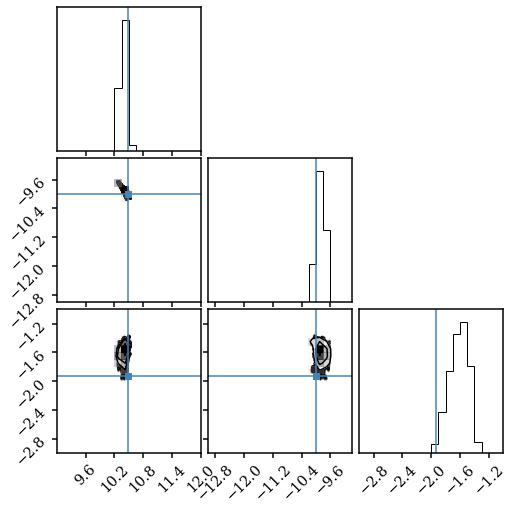

In [18]:
for i in range(50)[::10]: 
    theta_deriv = np.array([logMstar_inf[i], logSSFR_inf[i], logZ_MW_inf[i]])
    theta_true = np.array([logMstar_true[i], logSSFR_true[i], logZ_MW_true[i]])
    DFM.corner(theta_deriv.T, 
               truths=theta_true, 
              range=[(9, 12), (-13, -9.), (-3., -1)])

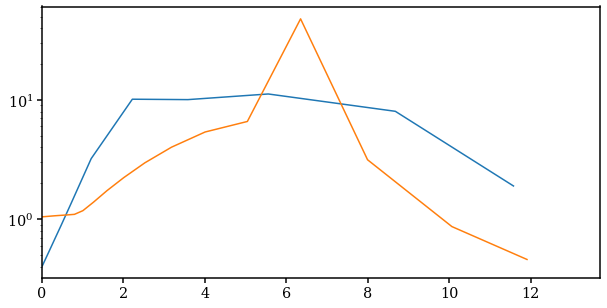

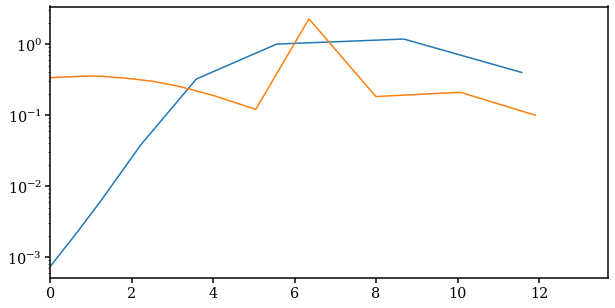

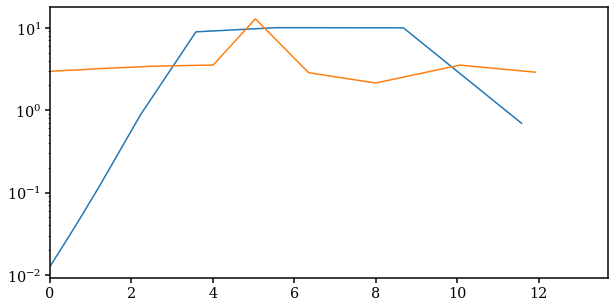

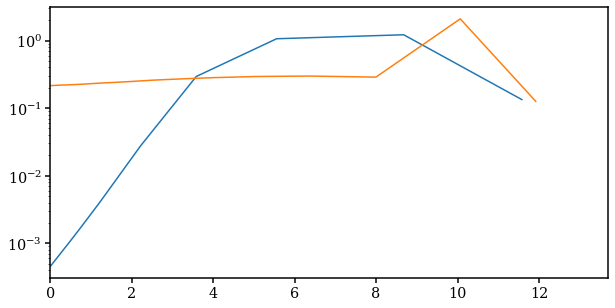

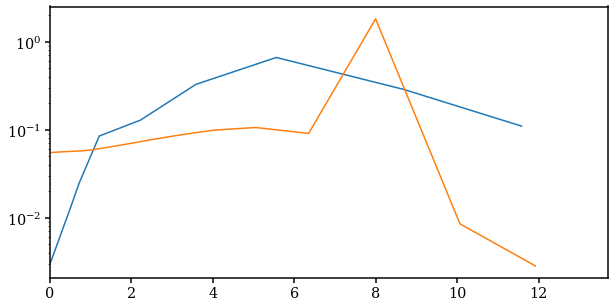

In [22]:
for i in np.arange(len(igals))[:5]:
    t, sfh = m_nmf.SFH(chains[i]['theta_bestfit'], zred=theta_obs['redshift'][igals[i]])
    
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    sub.plot(theta_obs['t_lookback'][igals[i]], (theta_obs['sfh_disk'][igals[i]] + theta_obs['sfh_bulge'][igals[i]])/ theta_obs['dt'][igals[i]] / 1e9)
    sub.plot(0.5*(t[1:]+t[:-1]), sfh)
    sub.set_xlim(0., 13.7)
    sub.set_yscale('log')

We reproduce stellar mass relatively well. There's a slight bias in log SSFR, where we're inferring lower than true SSFR 

In [25]:
bad_logm = (np.abs(logMstar_true - logm_q[:,1]) > 0.2)
print(np.sum(bad_logm))

9


(-3.0, -1)

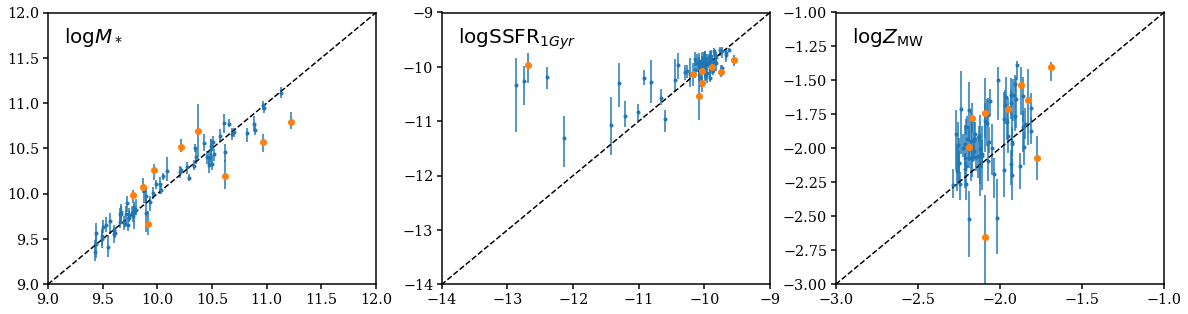

In [24]:
fig = plt.figure(figsize=(20,5))
sub = fig.add_subplot(131)
sub.errorbar(logMstar_true, logm_q[:,1], 
             yerr=[logm_q[:,1]-logm_q[:,0], logm_q[:,2]-logm_q[:,1]],
             fmt='.C0')
sub.scatter(logMstar_true[bad_logm], logm_q[bad_logm,1], c='C1', zorder=10)
sub.plot([9., 12.], [9., 12], c='k', ls='--')
sub.text(0.05, 0.95, r'$\log M_*$', transform=sub.transAxes, ha='left', va='top', fontsize=20)
sub.set_xlim(9., 12.)
sub.set_ylim(9., 12.)

sub = fig.add_subplot(132)
sub.errorbar(logSSFR_true, logssfr_q[:,1], 
             yerr=[logssfr_q[:,1]-logssfr_q[:,0], logssfr_q[:,2]-logssfr_q[:,1]], 
             fmt='.C0')
sub.scatter(logSSFR_true[bad_logm], logssfr_q[bad_logm,1], c='C1', zorder=10)
sub.plot([-9., -15.], [-9., -15], c='k', ls='--')
sub.text(0.05, 0.95, r'$\log {\rm SSFR}_{1Gyr}$', transform=sub.transAxes, ha='left', va='top', fontsize=20)
sub.set_xlim(-14, -9.)
sub.set_ylim(-14, -9.)

sub = fig.add_subplot(133)
sub.errorbar(logZ_MW_true, logzmw_q[:,1], 
             yerr=[logzmw_q[:,1] - logzmw_q[:,0], logzmw_q[:,2] - logzmw_q[:,1]], 
             fmt='.C0')
sub.scatter(logZ_MW_true[bad_logm], logzmw_q[bad_logm,1], c='C1', zorder=10)

sub.text(0.05, 0.95, r'$\log Z_{\rm MW}$', transform=sub.transAxes, ha='left', va='top', fontsize=20)
sub.plot([-3., -1], [-3, -1], c='k', ls='--')
sub.set_xlim(-3., -1)
sub.set_ylim(-3., -1)

It seems like we overpredict the stellar mass for the galaxies where we underpredict the SSFR

In [19]:
likes = []
# examine the chains     
for i, chain in zip(igals, chains): 
    likes.append(np.sum((chain['flux_photo_model'] - flux_obs[i][:3])**2 * ivar_obs[i][:3]))

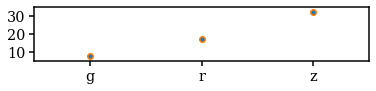

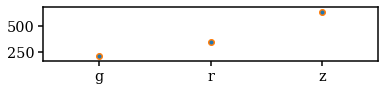

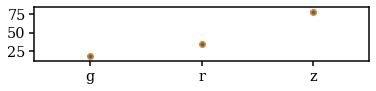

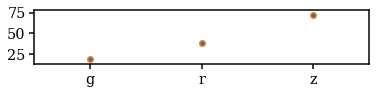

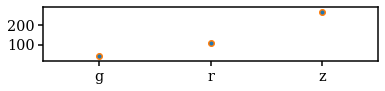

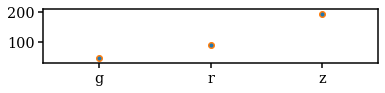

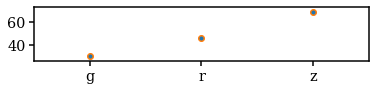

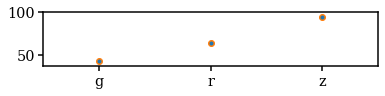

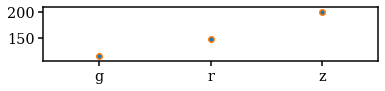

In [26]:
# examine the chains     
for ii in np.arange(len(bad_logm))[bad_logm]: 
    fig = plt.figure(figsize=(6,1))
    sub = fig.add_subplot(111)
    sub.errorbar(range(3), flux_obs[igals[ii]][:3], yerr=ivar_obs[igals[ii]][:3]**-0.5, fmt='.C0')
    sub.scatter(range(3), chains[ii]['flux_photo_model'], c='C1')
    sub.set_xlim(-0.5, 2.5)
    sub.set_xticks(range(3))
    sub.set_xticklabels(['g', 'r', 'z'])
